In [1]:
import pandas as pds
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
from pandasql import sqldf
import functools

## define function for printing pandas dataframes as markdown

In [2]:
def print_pandas_md(df):
    print(tabulate(df, tablefmt="pipe", headers="keys"))

## define function to round values in an interval object

In [3]:
def round_interval(interval):
    left_val = round(interval.left)
    right_val = round(interval.right)
    return pds.Interval(left=left_val, right=right_val, closed='left')

## helper fuction for showing values on bars
adapted from: https://stackoverflow.com/questions/43214978/seaborn-barplot-displaying-values

In [4]:
def show_values_on_bars(axs, h_v="v", horizontal_space=5, vertical_space=5, ha="center", va="bottom", fontsize=12):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + float(vertical_space)
                # print(p.get_height())
                value = int(p.get_height())
                value = f"{value:,}" # add comma to value
                ax.text(_x, _y, value, ha=ha, va=va, fontsize=fontsize) 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(horizontal_space)
                # print(p.get_width())
                _y = p.get_y() + p.get_height() / 2
                value = int(p.get_width())
                value = f"{value:,}" # add comma to value
                ax.text(_x, _y, value, ha=ha, va=va, fontsize=fontsize)

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

## load local copies of data

In [5]:
patient_df = pds.read_csv('triplestore-patient-info.tsv', sep='\t')

In [6]:
tooth_proc_df = pds.read_csv('triplestore-tooth-procedure-info.tsv', sep='\t')

In [7]:
tooth_type_df = pds.read_csv('triplestore-tooth-type-info.tsv', sep='\t')

In [8]:
proc_surface_df = pds.read_csv('triplestore-procedure-surface-info.tsv', sep='\t')

In [9]:
proc_material_df = pds.read_csv('triplestore-proc-material-info.tsv', sep='\t')

## getting some tooth info

In [52]:
tooth_proc_df.head()

,patient_id,tooth_id,tooth_num,proc_id,event,event_date,cdt_code,cdt_label
0,A_1_1_17,A_1_1_17_7,7,A_1_1_17_7_D2331_2011-04-23,resin filling restoration procedure,2011-04-23,D2331,"resin-based composite - two surfaces, anterior"
1,A_1_1_17,A_1_1_17_9,9,A_1_1_17_9_D2335_2006-07-07,resin filling restoration procedure,2006-07-07,D2335,resin-based composite - four or more surfaces ...
2,A_1_1_17,A_1_1_17_10,10,A_1_1_17_10_D2330_2008-10-12,resin filling restoration procedure,2008-10-12,D2330,"resin-based composite - one surface, anterior"
3,A_1_1_17,A_1_1_17_10,10,A_1_1_17_10_D2335_2014-03-16,resin filling restoration procedure,2014-03-16,D2335,resin-based composite - four or more surfaces ...
4,A_1_1_17,A_1_1_17_12,12,A_1_1_17_12_D2392_2012-01-23,resin filling restoration procedure,2012-01-23,D2392,"resin-based composite - two surfaces, posterior"


In [54]:
# temp_df = tooth_proc_df

In [56]:
temp_df = tooth_proc_df[tooth_proc_df.event.str.contains('restoration')]

In [57]:
len(temp_df)

1508527

In [58]:
temp_df2 = tooth_proc_df[tooth_proc_df.event.str.contains('endodontic')]

In [59]:
len(temp_df2)

73672

# Plot data

## plot total number of distinct teeth by tooth type that underwent a procedure

### calculate the number of each tooth type

In [10]:
tooth_df = tooth_proc_df[['patient_id', 'tooth_num']].copy()
tooth_df.tooth_num = tooth_df.tooth_num.astype(int)
tooth_count_query = """
select 
    tooth_num, count(*) as num_teeth
from
    tooth_df
group by
    tooth_num
order by
    tooth_num
"""
tooth_count_df = sqldf(tooth_count_query)

In [11]:
# tooth_count_df.head()

### plot

/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_27943/673825536.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), size=16)
/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_27943/673825536.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()]) # put commas in y-ticks


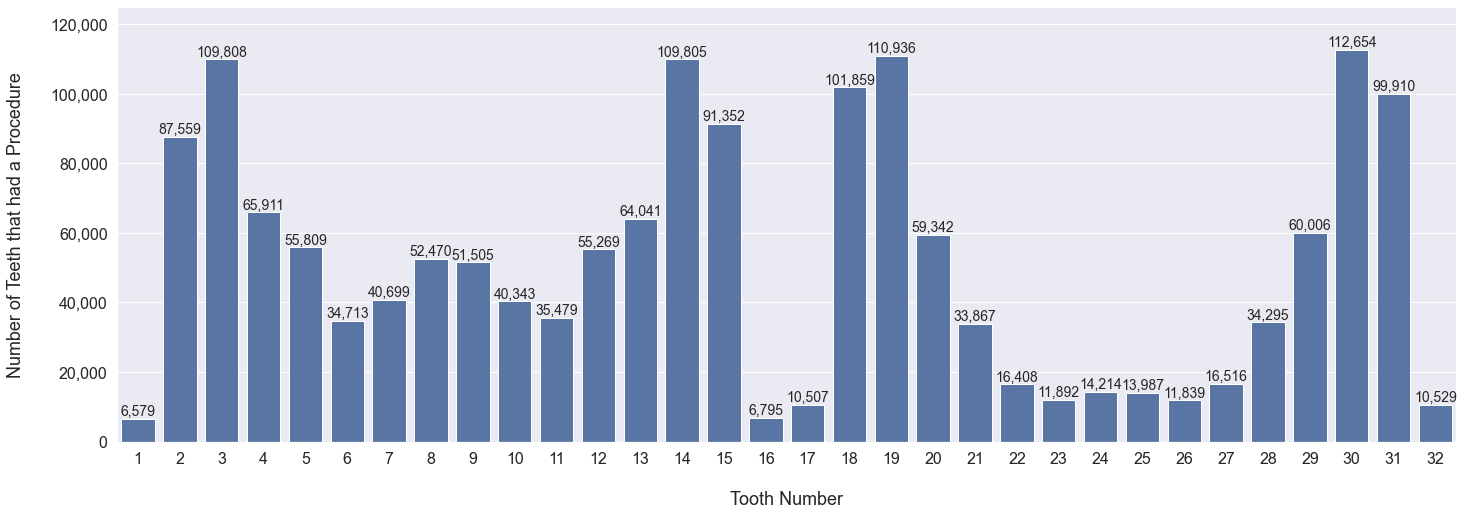

In [12]:
%matplotlib inline
sns.set()

plt.figure(figsize=(24,8))
ax = sns.barplot(x='tooth_num', y='num_teeth',data=tooth_count_df, color='#4c72b0')

ax.set_xlabel("\nTooth Number", fontsize=18)
ax.set_ylabel("Number of Teeth that had a Procedure\n", fontsize=18)

tooth_nums = [x for x in range(1,33)] # create list of tooth nums
ax.set_xticklabels(tooth_nums, size=16)
ax.set_yticklabels(ax.get_yticks(), size=16)

ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()]) # put commas in y-ticks

## put numbers on each bar
show_values_on_bars(ax, h_v="v", vertical_space=100, fontsize=14)

## add extra room at top of figure
ax.set_ylim(0, 125000)

# plt.savefig("figures/tooth-count-per-tooth.png", dpi=600, bbox_inches="tight")
plt.show()

## plot total number of distinct teeth by tooth type that underwent a procedure by gender

### join tooth information to gender information

In [13]:
tooth_gender_query = """
select
    tooth_df.patient_id, tooth_num, gender
from
    tooth_df
inner join
    patient_df
on
    tooth_df.patient_id = patient_df.patient_id
order by
    tooth_num
"""
tooth_gender_df = sqldf(tooth_gender_query)

### calculate the number of teeth for each tooth type and gender

In [14]:
tooth_gender_count_query = """
select 
    tooth_num, gender, count(*) as num_teeth
from
    tooth_gender_df
group by
    tooth_num, gender
order by
    tooth_num
"""
tooth_gender_count_df = sqldf(tooth_gender_count_query)

In [15]:
# tooth_gender_count_df.head()

### plot

/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_27943/3574107685.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), size=13)
/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_27943/3574107685.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()]) # put commas in y-ticks


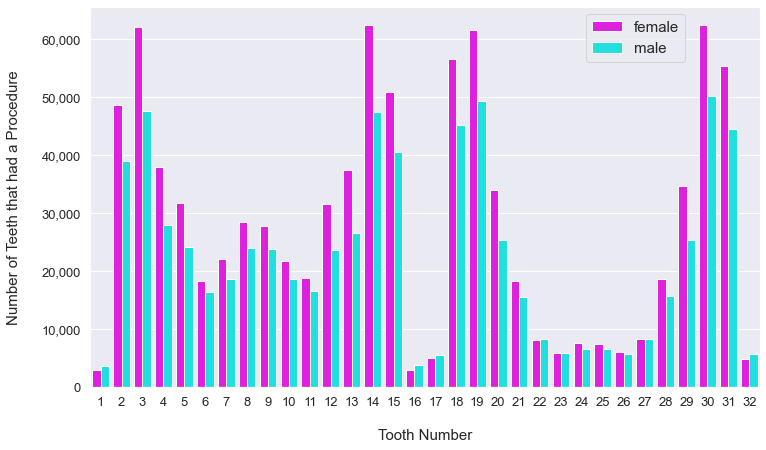

In [16]:
%matplotlib inline
sns.set()
colors = ['magenta', 'cyan']
sns.set_palette(colors)

plt.figure(figsize=(12,7))
ax = sns.barplot(x='tooth_num', y='num_teeth', hue="gender",data=tooth_gender_count_df)

ax.set_xlabel("\nTooth Number", fontsize=15)
ax.set_ylabel("Number of Teeth that had a Procedure\n", fontsize=15)

tooth_nums = [x for x in range(1,33)] # create list of tooth nums
ax.set_xticklabels(tooth_nums, size=13)
ax.set_yticklabels(ax.get_yticks(), size=13)
ax.legend(loc='upper right', fontsize=15, bbox_to_anchor=(0.9, 1))

ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()]) # put commas in y-ticks
plt.savefig("figures/tooth-count-per-tooth-by-gender.png", dpi=600, bbox_inches="tight")
plt.show()

## create table with tooth number totals for females, males, and all (i.e., males and females)
### this table is helpful for error checking and putting into paper

In [17]:
## this looks a little hairy, but it only a merger of two queries
## followed by the subset of data we want
## followed by renaming the columns output by the merge
gender_count_table = \
    pds.merge(tooth_gender_count_df.query("gender == 'female'"),
    tooth_gender_count_df.query("gender == 'male'"),
    how='inner',
    on='tooth_num')[['tooth_num', 'num_teeth_x', 'num_teeth_y']].rename(columns={'num_teeth_x': 'female', 'num_teeth_y': 'male'})

In [18]:
# gender_count_table.head()

In [19]:
## merge gender counts with the totals of all teet
all_tooth_count_table = \
    pds.merge(gender_count_table, tooth_count_df, how='inner', on='tooth_num').rename(columns={'num_teeth': 'total'})

In [20]:
all_tooth_count_table.head()

,tooth_num,female,male,total
0,1,2956,3623,6579
1,2,48644,38915,87559
2,3,62118,47690,109808
3,4,37956,27955,65911
4,5,31684,24125,55809


## summarize number of surfaces restored

In [21]:
proc_surface_df.head()

,patient_id,tooth_id,tooth_num,proc_id,m,o,d,b,f,l,i,num_surfaces
0,A_1_1_17,A_1_1_17_7,7,A_1_1_17_7_D2331_2011-04-23,1,0,0,0,0,0,1,2
1,A_1_1_17,A_1_1_17_9,9,A_1_1_17_9_D2335_2006-07-07,1,0,0,0,0,0,1,2
2,A_1_1_17,A_1_1_17_10,10,A_1_1_17_10_D2330_2008-10-12,1,0,0,0,0,0,0,1
3,A_1_1_17,A_1_1_17_10,10,A_1_1_17_10_D2335_2014-03-16,1,0,0,0,1,1,1,4
4,A_1_1_17,A_1_1_17_12,12,A_1_1_17_12_D2392_2012-01-23,0,1,1,0,0,0,0,2


In [22]:
surface_proc_count_query = """
select 
    sum(m) as M,
    sum(o) as O,
    sum(d) as D,
    sum(b) as B,
    sum(f) as F,
    sum(l) as L,
    sum(i) as I
from
    proc_surface_df
"""
surface_proc_count_df = sqldf(surface_proc_count_query)

In [23]:
surface_proc_count_df

,M,O,D,B,F,L,I
0,349287,828423,379686,89869,293902,288136,34517


### melt dataframe for plotting

In [24]:
surface_melt_df = pds.melt(surface_proc_count_df, value_vars=['M', 'O', 'D', 'B', 'F', 'L', 'I'], var_name='surface', value_name='total')

In [25]:
surface_melt_df

,surface,total
0,M,349287
1,O,828423
2,D,379686
3,B,89869
4,F,293902
5,L,288136
6,I,34517


### plot

/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_27943/3383926710.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_yticks(), size=14)
No handles with labels found to put in legend.
/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_27943/3383926710.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()]) # put commas in x-ticks


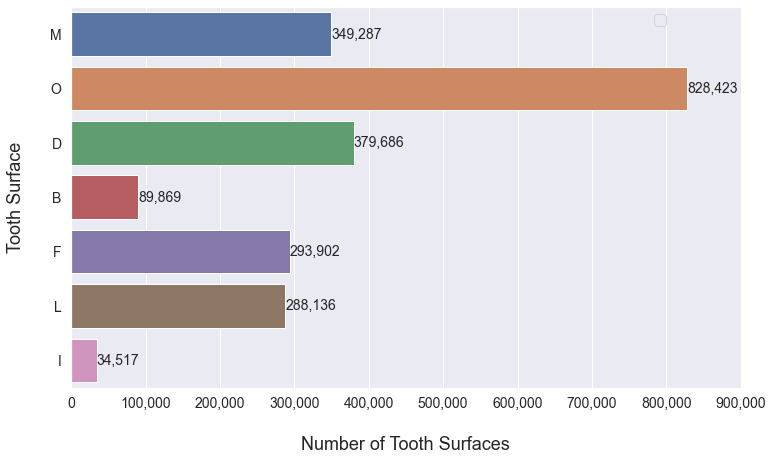

In [26]:
%matplotlib inline
sns.set()

plt.figure(figsize=(12,7))
ax = sns.barplot(x='total', y='surface', data=surface_melt_df)

ax.set_xlabel("\nNumber of Tooth Surfaces", fontsize=18)
ax.set_ylabel("Tooth Surface\n", fontsize=18)

y_ticks = ['M', 'O', 'D', 'B', 'F', 'L', 'I']
ax.set_xticklabels(ax.get_yticks(), size=14)
ax.set_yticklabels(y_ticks, size=14)

ax.legend(loc='upper right', fontsize=15, bbox_to_anchor=(0.9, 1))

ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks().tolist()]) # put commas in x-ticks

## put numbers on each bar
show_values_on_bars(ax, h_v="h", horizontal_space=30, ha="left", va="center", fontsize=14)

## add extra room for numbers
ax.set_xlim(0, 900000)

plt.savefig("figures/surfaces-restored-count.png", dpi=600, bbox_inches="tight")
plt.show()

## summarize number of surfaces restored for each tooth type

In [27]:
tooth_surface_proc_count_query = """
select
    case 
        when incisor = 1 then 'incisor'
        when canine = 1 then 'canine'
        when premolar = 1 then 'premolar'
        when molar = 1 then 'molar'
    end as tooth_type,
    case 
        when num_surfaces = 1 then '1 surface'
        when num_surfaces = 2 then '2 surfaces'
        when num_surfaces > 2 then '3+ surfaces'
    end as surface_category,
    count(*) as total
from 
    proc_surface_df
inner join
    tooth_type_df
on 
    proc_surface_df.tooth_id = tooth_type_df.tooth_id
where 
    num_surfaces > 0
group by 
    tooth_type, surface_category
order by
    surface_category, tooth_type
"""
tooth_surface_proc_count_df = sqldf(tooth_surface_proc_count_query)

In [28]:
tooth_surface_proc_count_df

,tooth_type,surface_category,total
0,canine,1 surface,39039
1,incisor,1 surface,65656
2,molar,1 surface,305022
3,premolar,1 surface,112547
4,canine,2 surfaces,25324
5,incisor,2 surfaces,60660
6,molar,2 surfaces,242478
7,premolar,2 surfaces,140076
8,canine,3+ surfaces,15874
9,incisor,3+ surfaces,62067


### plot

/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_27943/1789550321.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), size=13)
/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_27943/1789550321.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()]) # put commas in y-ticks


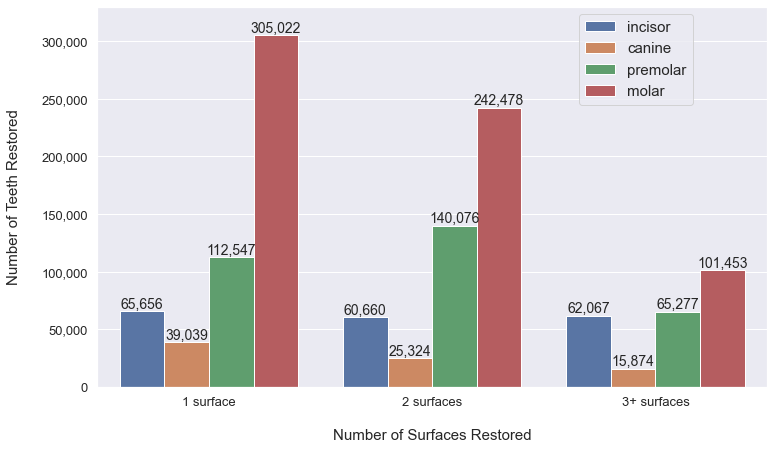

In [29]:
%matplotlib inline
sns.set()

plt.figure(figsize=(12,7))
ax = sns.barplot(x='surface_category', y='total', data=tooth_surface_proc_count_df,
                 hue="tooth_type", hue_order=['incisor', 'canine', 'premolar', 'molar'])

ax.set_xlabel("\nNumber of Surfaces Restored", fontsize=15)
ax.set_ylabel("Number of Teeth Restored\n", fontsize=15)

x_ticks = ['1 surface', '2 surfaces', '3+ surfaces']
ax.set_xticklabels(x_ticks, size=13)
ax.set_yticklabels(ax.get_yticks(), size=13)

ax.legend(loc='upper right', fontsize=15, bbox_to_anchor=(0.9, 1))

ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()]) # put commas in y-ticks

## put numbers on each bar
show_values_on_bars(ax, h_v="v", vertical_space=100, fontsize=14)

## add extra room at top of figure
ax.set_ylim(0, 330000)

plt.savefig("figures/surfaces-restored-by-tooth-type-count.png", dpi=600, bbox_inches="tight")
plt.show()

## summarize materials used for tooth type

### create a column with three general categories of materials: ceramic, metal, resin

In [30]:
def get_material_category(material):
    if pds.isnull(material): return material
    
    if material in ['ceramic', 'porcelain']:
        return 'ceramic'
    elif material in ['metal', 'predominantly base metal', 'stainless steel', 'noble metal', 'high noble metal', 'amalgam', 'gold foil']:
        return 'metal'
    elif material in ['resin']:
        return 'resin'
    else:
        return None

In [31]:
proc_material_df['material_category'] = proc_material_df['material'].map(lambda x: get_material_category(x))

In [32]:
# proc_material_df.head()

### build data frame of each the material used in each tooth
### note: use dropna to remove procedures with no materials

In [33]:
tooth_material_proc_df = \
    pds.merge(proc_material_df.dropna(), 
              tooth_type_df[['tooth_id','anterior','posterior','incisor','canine','premolar','molar','maxillary','mandibular','left','right']], 
              how='inner', 
              on='tooth_id')

In [34]:
# tooth_material_proc_df.head()

In [35]:
tooth_material_proc_count_df = \
    tooth_material_proc_df[['material_category','incisor','canine','premolar','molar']].groupby('material_category').sum()
tooth_material_proc_count_df.reset_index(inplace=True)

In [36]:
 tooth_material_proc_count_df

,material_category,incisor,canine,premolar,molar
0,ceramic,30916,13267,67849,126982
1,metal,18299,11171,86910,214456
2,resin,187773,78645,283226,546268


### melt dataframe for plotting

In [37]:
tooth_material_proc_count_melt_df = \
    tooth_material_proc_count_df.melt(id_vars=['material_category'], var_name='tooth_type', 
                                      value_vars=['incisor', 'canine', 'premolar', 'molar'], value_name='total')

In [38]:
tooth_material_proc_count_melt_df

,material_category,tooth_type,total
0,ceramic,incisor,30916
1,metal,incisor,18299
2,resin,incisor,187773
3,ceramic,canine,13267
4,metal,canine,11171
5,resin,canine,78645
6,ceramic,premolar,67849
7,metal,premolar,86910
8,resin,premolar,283226
9,ceramic,molar,126982


### plot

/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_27943/874321747.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), size=15)
/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_27943/874321747.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()]) # put commas in y-ticks


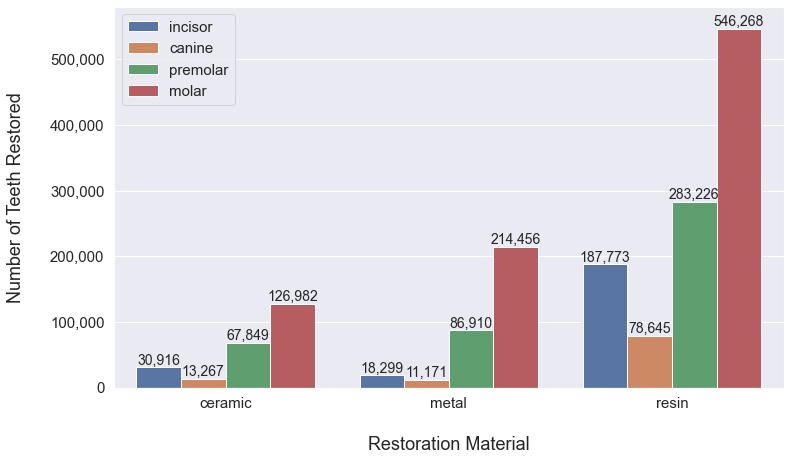

In [39]:
%matplotlib inline
sns.set()

plt.figure(figsize=(12,7))
ax = sns.barplot(x='material_category', y='total', data=tooth_material_proc_count_melt_df, hue='tooth_type')

ax.set_xlabel("\nRestoration Material", fontsize=18)
ax.set_ylabel("Number of Teeth Restored\n", fontsize=18)

x_ticks = ['ceramic', 'metal', 'resin']
ax.set_xticklabels(x_ticks, size=15)
ax.set_yticklabels(ax.get_yticks(), size=15)

ax.legend(loc='upper left', fontsize=15)

ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()]) # put commas in y-ticks

## put numbers on each bar
show_values_on_bars(ax, h_v="v", vertical_space=100, fontsize=14)

## add extra room at top of figure
ax.set_ylim(0, 580000)

plt.savefig("figures/restoration-materials-per-tooth-count.png", dpi=600, bbox_inches="tight")
plt.show()

## plot material use over time

### add procedure dates to the tooth/materal dataframe

In [40]:
tooth_material_proc_date_df = \
    pds.merge(tooth_material_proc_df, tooth_proc_df[['proc_id', 'event_date']], how='inner', on='proc_id')
tooth_material_proc_date_df.event_date = pds.to_datetime(tooth_material_proc_date_df.event_date)
tooth_material_proc_date_df['event_year'] = pds.DatetimeIndex(tooth_material_proc_date_df.event_date).year

### drop any years > 2015

In [41]:
tooth_material_proc_date_df = tooth_material_proc_date_df[tooth_material_proc_date_df.event_year < 2016]

In [42]:
material_proc_date_count_df = \
    pds.DataFrame(tooth_material_proc_date_df.groupby(['event_year', 'material_category'])['material_category']\
                  .count())\
                  .rename(columns={'material_category': 'total'})\
                  .reset_index()

In [43]:
material_proc_date_count_df[material_proc_date_count_df.event_year > 2013]

,event_year,material_category,total
98,2014,ceramic,15266
99,2014,metal,12238
100,2014,resin,85261
101,2015,ceramic,13870
102,2015,metal,9641
103,2015,resin,75311


### plot

/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_27943/1300804759.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])


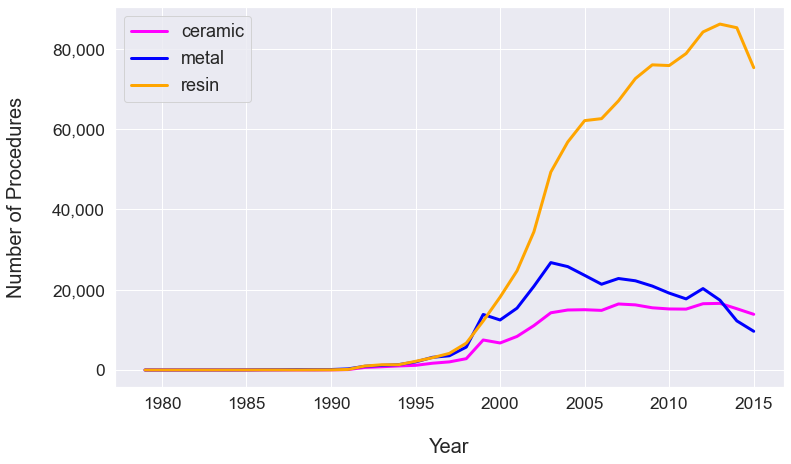

In [44]:
%matplotlib inline
sns.set()
sns.set_context(rc={"lines.linewidth": 3})
colors = ['magenta', 'blue', 'orange']
sns.set_palette(colors)

plt.figure(figsize=(12,7))
ax = sns.lineplot(x="event_year", y="total", data=material_proc_date_count_df, hue="material_category", legend=False)

ax.set_xlabel("\nYear", fontsize=20)
ax.set_ylabel("Number of Procedures\n", fontsize=20)

ax.tick_params(labelsize='x-large') # use large labels
plt.xticks(rotation=0)  # rotate the ticks on the x axis

## put commas in y-ticks
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])

plt.legend(loc='upper left', labels=['ceramic', 'metal', 'resin'], prop={'size': 18})
plt.savefig("figures/materials-used-by-year-line.png", dpi=600, bbox_inches="tight")
plt.show()

### plot tooth by matial use over time

In [45]:
# tooth_material_proc_date_df.head()

In [46]:
tooth_material_over_time_count_df = \
    pds.DataFrame(tooth_material_proc_date_df[['material_category', 'event_year', 'anterior', 'posterior']]\
                  .groupby(['event_year','material_category'])
                  .sum())\
                  .reset_index()

In [47]:
# tooth_material_over_time_count_df.head()

In [48]:
tooth_material_over_time_count_df[tooth_material_over_time_count_df.event_year > 2013]

,event_year,material_category,anterior,posterior
98,2014,ceramic,2753,12513
99,2014,metal,1181,11057
100,2014,resin,18068,67193
101,2015,ceramic,2320,11550
102,2015,metal,901,8740
103,2015,resin,16839,58472


### melt dataframe for plotting

In [49]:
tooth_material_over_time_count_melt_df = \
    tooth_material_over_time_count_df.melt(id_vars=['material_category', 'event_year'], var_name='tooth_type', 
                                           value_vars=['anterior', 'posterior'], value_name='total')

In [50]:
tooth_material_over_time_count_melt_df[tooth_material_over_time_count_melt_df.event_year > 2013]

,material_category,event_year,tooth_type,total
98,ceramic,2014,anterior,2753
99,metal,2014,anterior,1181
100,resin,2014,anterior,18068
101,ceramic,2015,anterior,2320
102,metal,2015,anterior,901
103,resin,2015,anterior,16839
202,ceramic,2014,posterior,12513
203,metal,2014,posterior,11057
204,resin,2014,posterior,67193
205,ceramic,2015,posterior,11550


### plot

/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_27943/1941184820.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0,0].set_xticklabels(g.axes[0,0].get_xticklabels(), size=20)
/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_27943/1941184820.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0,1].set_xticklabels(g.axes[0,1].get_xticklabels(), size=20)
/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_27943/1941184820.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0,0].set_yticklabels(g.axes[0,0].get_yticklabels(), size=20)
/var/folders/y_/64f732h167b9rmtn1k_dc8f00000gn/T/ipykernel_27943/1941184820.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.axes[0,0].set_yticklabels(['{:,}'.format(int(x)) for x in g.axes[0,0].get_yticks().tolist()])


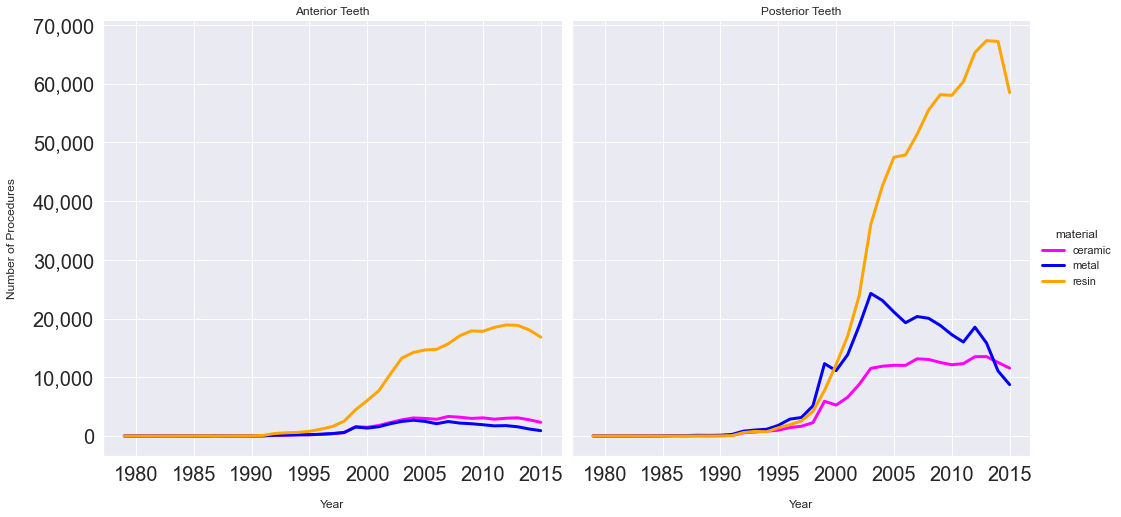

In [51]:
%matplotlib inline
sns.set_context(rc={"lines.linewidth": 3})
colors = ['magenta', 'blue', 'orange']
sns.set_palette(colors)

g = sns.FacetGrid(tooth_material_over_time_count_melt_df, col='tooth_type', hue='material_category', height=7)
g = g.map(sns.lineplot, 'event_year', 'total', ci=None).add_legend(title="material")

## set x and y labels
g.axes[0,0].set_xlabel('\nYear')
g.axes[0,1].set_xlabel('\nYear')
g.axes[0,0].set_ylabel('Number of Procedures\n')

## set title for left and right
g.axes[0,0].set_title('Anterior Teeth')
g.axes[0,1].set_title('Posterior Teeth')


## set size of xticks
g.axes[0,0].set_xticklabels(g.axes[0,0].get_xticklabels(), size=20)
g.axes[0,1].set_xticklabels(g.axes[0,1].get_xticklabels(), size=20)

## set size of y ticks and add commas to numbers
g.axes[0,0].set_yticklabels(g.axes[0,0].get_yticklabels(), size=20)
g.axes[0,0].set_yticklabels(['{:,}'.format(int(x)) for x in g.axes[0,0].get_yticks().tolist()])

plt.savefig("figures/tooth-and-materials-used-by-year-line.png", dpi=600, bbox_inches="tight")
plt.show()